# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
#require('torch')
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper
import fc_model
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
training_data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                               transforms.RandomResizedCrop(224), 
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ToTensor(), 
                                               transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

validaiton_data_transforms = transforms.Compose([transforms.Resize(256),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(), 
                                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_data_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(), 
                                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
# TODO: Load the datasets with ImageFolder
train_image_dataset = datasets.ImageFolder(train_dir, transform = training_data_transforms)
valid_image_dataset = datasets.ImageFolder(valid_dir, transform = validaiton_data_transforms)
test_image_dataset = datasets.ImageFolder(test_dir, transform = test_data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_image_dataset, batch_size = 32, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_image_dataset, batch_size = 32, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size = 32, shuffle = True)

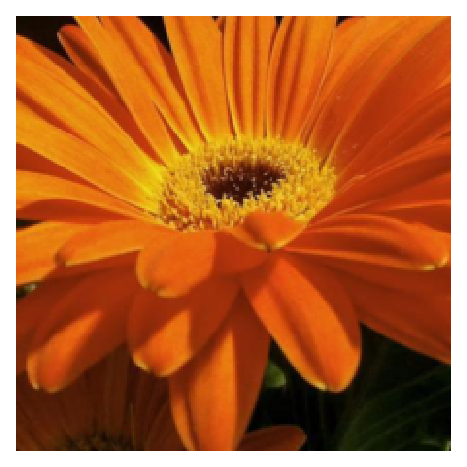

In [4]:
data_iter = iter(valid_dataloader)
images, labels = next(data_iter)
helper.imshow(images[0],normalize = True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:28<00:00, 22760818.96it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
# TODO: Build and train your network
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#Set default tensor type, then move model and data to GPU
torch.set_default_tensor_type('torch.FloatTensor')

In [9]:
# TODO: Build and train your network
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [10]:
# TODO: Build and train your network
#Define our new classifier which we will be training
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(25088, 1500)),
                            ('relu', nn.ReLU()),
                            ('dropout',nn.Dropout(.2)),
                            ('fc2', nn.Linear(1500,102)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))

In [11]:
# TODO: Build and train your network
#We have created our classifier, now let's attach this to our model
model.classifier = classifier

In [12]:
# TODO: Build and train your network
#let's check our model now is the way we want it, thus the last classifier for the CNN VGG network is the way we defined it
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [13]:
# TODO: Build and train your network
#Here I define my loss
#Since our last laye is LogSoftmax we use Negative Log Likelihood loss function NLLLoss()
criterion = nn.NLLLoss()

In [14]:
# TODO: Build and train your network
#Here I defime my optimizer
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [15]:
# TODO: Build and train your network
#move the model to whichever device we have available
model.to(device);

In [16]:
# TODO: Build and train your network
#Now we have the model setup so we are ready to train it

#Define variables we will be using during the training
epochs = 5 
steps = 0 #we will track the number of trainsteps we do so we set this to zero
training_loss = 0 #we wil track the training loss we do so we set this to zero
print_every = 50
for epoch in range(epochs):
    for images, labels in train_dataloader: #loop into our data (images)
        steps += 1 #cumulate steps. Every time we go through one of these batches, we will increment steps here
        images, labels = images.to(device), labels.to(device)# Move input and label tensors to the default device
        optimizer.zero_grad() #Here we zero our gradients in order not to have leftover values from previous loops
        
        log_ps = model.forward(images) #get our log probabilities from our model
        
        loss = criterion(log_ps, labels) #We get the loss from the criterion
        loss.backward() #We do a backwards pass
        optimizer.step() #With the optimizer we take a step
        training_loss += loss.item() #Here we increment our training loss - This is where we keep track of our training loss
               
        ### This is where our training loop ends ###
        ### Now we drop out of our training loop to test our network's accuracy and loss on our validation dataset ###
        
        
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval() # this turns our model to the evaluation inference mode which turns off Dropout
            # In this way we can accurately use our network for making predictions

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for images, labels in valid_dataloader:
                    images, labels = images.to(device), labels.to(device)

                    output = model.forward(images)
                    #images, labels = images.to(device), labels.to(device) #transfer my tensors to the GPU
                    log_ps = model(images) #with the model we already have we will pass images from our validation dataset
                    valid_loss += criterion(log_ps, labels) #get loss from validation dataset
                
                    #calculate accuracy
                    ps = torch.exp(log_ps) #our model returns log probabilities, so to get crude probabilities we do this
                    top_p, top_class = ps.topk(1, dim=1) #here we get top probabilities and top classes using ps.topk()
                    equality = top_class == labels.view(*top_class.shape) #check for equality with our labels
                    accuracy += torch.mean(equality.type(torch.FloatTensor)) #with equality tensor we update our accuracy

            print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {training_loss/print_every:.3f}.. "
                f"Valid loss: {valid_loss/len(valid_dataloader):.3f}.. "
                f"Valid accuracy: {accuracy/len(valid_dataloader):.3f}")
                
            training_loss = 0 #we set our training loss back to zero
            model.train() #we set our model in training mode - we now use the dropout

Epoch 1/5.. Train loss: 4.186.. Valid loss: 3.470.. Valid accuracy: 0.260
Epoch 1/5.. Train loss: 3.348.. Valid loss: 2.422.. Valid accuracy: 0.477
Epoch 1/5.. Train loss: 2.676.. Valid loss: 1.770.. Valid accuracy: 0.608
Epoch 1/5.. Train loss: 2.153.. Valid loss: 1.402.. Valid accuracy: 0.681
Epoch 2/5.. Train loss: 1.809.. Valid loss: 1.166.. Valid accuracy: 0.731
Epoch 2/5.. Train loss: 1.587.. Valid loss: 0.982.. Valid accuracy: 0.762
Epoch 2/5.. Train loss: 1.442.. Valid loss: 0.926.. Valid accuracy: 0.771
Epoch 2/5.. Train loss: 1.362.. Valid loss: 0.736.. Valid accuracy: 0.832
Epoch 3/5.. Train loss: 1.172.. Valid loss: 0.716.. Valid accuracy: 0.822
Epoch 3/5.. Train loss: 1.096.. Valid loss: 0.631.. Valid accuracy: 0.846
Epoch 3/5.. Train loss: 1.088.. Valid loss: 0.653.. Valid accuracy: 0.829
Epoch 3/5.. Train loss: 0.996.. Valid loss: 0.541.. Valid accuracy: 0.876
Epoch 4/5.. Train loss: 0.947.. Valid loss: 0.526.. Valid accuracy: 0.868
Epoch 4/5.. Train loss: 0.934.. Valid 

In [17]:
images.shape

torch.Size([24, 3, 224, 224])

In [18]:
images.to(device)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -0.6452, -0.5767, -0.5253],
          [-2.1179, -2.1179, -1.9295,  ..., -0.5082, -0.4568, -0.4226],
          [-2.1179, -2.1179, -1.8953,  ..., -0.4911, -0.4397, -0.4226],
          ...,
          [ 0.3481,  0.2624,  0.1597,  ...,  2.1462,  2.1633,  2.1633],
          [ 0.2282,  0.1597,  0.0741,  ...,  2.0948,  2.0948,  2.0948],
          [ 0.2967,  0.2282,  0.1426,  ...,  2.0777,  2.0777,  2.0777]],

         [[-2.0357, -2.0357, -2.0357,  ...,  0.1877,  0.2402,  0.2927],
          [-2.0357, -2.0357, -1.7906,  ...,  0.2227,  0.2752,  0.3102],
          [-2.0357, -2.0357, -1.7556,  ...,  0.1702,  0.2227,  0.2227],
          ...,
          [ 1.0455,  0.9930,  0.9055,  ...,  0.0476,  0.0476,  0.0476],
          [ 0.9405,  0.8704,  0.7654,  ...,  0.0126,  0.0301,  0.0301],
          [ 1.0455,  0.9580,  0.8179,  ..., -0.0049,  0.0126,  0.0126]],

         [[-1.8044, -1.8044, -1.8044,  ..., -0.7761, -0.6541, -0.5844],
          [-1.8044, -1.8044, -

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
print_every = 50
model.eval() # this turns our model to the evaluation inference mode which turns off Dropout
            # In this way we can accurately use our network for making predictions
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device) #transfer my tensors to the GPU
        log_ps = model(images) #with the model we already have we will pass images from our validation dataset
        test_loss += criterion(log_ps, labels) #get loss from validation dataset
                
        #calculate accuracy
        ps = torch.exp(log_ps) #our model returns log probabilities, so to get crude probabilities we do this
        top_p, top_class = ps.topk(1, dim=1) #here we get top probabilities and top classes using ps.topk()
        equality = top_class == labels.view(*top_class.shape) #check for equality with our labels
        accuracy += torch.mean(equality.type(torch.FloatTensor)) #with equality tensor we update our accuracy
                

        print(f"Train loss: {test_loss/print_every:.3f}.. "
                f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
                f"Test accuracy: {accuracy/len(test_dataloader):.3f}")

Train loss: 0.012.. Test loss: 0.023.. Test accuracy: 0.034
Train loss: 0.027.. Test loss: 0.051.. Test accuracy: 0.065
Train loss: 0.038.. Test loss: 0.074.. Test accuracy: 0.097
Train loss: 0.046.. Test loss: 0.088.. Test accuracy: 0.130
Train loss: 0.057.. Test loss: 0.110.. Test accuracy: 0.162
Train loss: 0.063.. Test loss: 0.121.. Test accuracy: 0.198
Train loss: 0.069.. Test loss: 0.132.. Test accuracy: 0.233
Train loss: 0.080.. Test loss: 0.154.. Test accuracy: 0.263
Train loss: 0.099.. Test loss: 0.191.. Test accuracy: 0.291
Train loss: 0.109.. Test loss: 0.210.. Test accuracy: 0.323
Train loss: 0.126.. Test loss: 0.242.. Test accuracy: 0.350
Train loss: 0.134.. Test loss: 0.257.. Test accuracy: 0.381
Train loss: 0.138.. Test loss: 0.265.. Test accuracy: 0.418
Train loss: 0.158.. Test loss: 0.304.. Test accuracy: 0.447
Train loss: 0.168.. Test loss: 0.323.. Test accuracy: 0.481
Train loss: 0.173.. Test loss: 0.333.. Test accuracy: 0.518
Train loss: 0.182.. Test loss: 0.350.. T

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
# TODO: Save the checkpoint 
#Now that we have our network trained, we can save it to a file, what's called the state_dict
#state_dict is a dictionary that contains all the parameters for our model - all weights and bias tensors.

#print out our model
print("Our model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys(), "\n")

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [27]:
#save the state_dict() with torch.save to a checkpoint.pth
#model_ft, train_losses = train_model(model, criterion, optimizer, exp_num_epocs = 15)
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'arch' : 'vgg16',
              'input_size' : 25088,
              'hidden_layers': 1500,
              'output_size': 102, 
              'classifier': model.classifier,
              'state_dict' : model.state_dict(),
              'model.class_to_idx' : train_image_dataset.class_to_idx,
              'epochs' : 5,
              'state_optimizer': optimizer.state_dict()}

#checkpoint = {'arch': 'vgg16',
#              'state_dict' : model_ft.state_dict(),
#              'class_to_idx': model_ft.class_to_idx,
#              'weights': model_ft.features}
torch.save(checkpoint,'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
#def load_checkpoint(filename):
#    checkpoint = torch.load(filename)
#  
#    
#    if checkpoint['arch'] == 'vgg16':
#        model = models.vgg16(pretrained=True)
#        for param in model.parameters():
#            param.requires_grad = False
#    else:
#        print("Not compatible network Architecture")
#        
#   
#    model.class_to_idx = checkpoint['class_to_idx']
#    
#    classifier = nn.Sequential(OrderedDict([
#                          ('fc1', nn.Linear(25088, 4096)),
#                          ('relu', nn.ReLU()),
#                          ('fc2', nn.Linear(4096, 102)),
#                          ('dropout',nn.Dropout(.2)),
#                          ('output', nn.LogSoftmax(dim=1))
#                          ]))
#    
#    # Replace VGG's classifier with our own classifier
#    model.classifier = classifier
#    model = getattr(models, checkpoint['arch'])
#    
#    model.load_state_dict(checkpoint['state_dict'])
      
#    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
#    optimizer.load_state_dict(checkpoint['state_optimizer'])

#     return (model, optimizer, criterion)
    


#print(model)
    # Freeze parameters
    

     #for param in model.parameters():
      #  param.requires_grad = False
       # classifier = nn.Sequential(OrderedDict([
        #                    ('fc1', nn.Linear(25088, 1500)),
         #                   ('relu', nn.ReLU()),
          #                  ('dropout',nn.Dropout(.2)),
           #                 ('fc2', nn.Linear(1500,102)),
            #                ('output', nn.LogSoftmax(dim=1))
             #               ]))
       # classifier.load_state_dict(checkpoint['state_dict'])
    #model.classifier = classifier
   # model.class_to_idx = checkpoint['model.class_to_idx']
    #criterion = nn.NLLLoss()
    #optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    #optimizer.load_state_dict(checkpoint['state_optimizer'])
    #return (model, optimizer, criterion)""" 


#(model, criterion, optimizer) = load_checkpoint('checkpoint.pth')

#print(model)


In [32]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filename):
    
    #load the checkpoint
    checkpoint = torch.load(filename)
    
    #access the arch key of the checkpoint
    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
    else:
        print("Not compatible network Architecture")
        
    #I use the arch key of the checkpoint
    #to initialize the correct pre-trained model
    model = getattr(models, checkpoint['arch'])  
    
    #After initializing the correct pre-trainned model
    # I freeze parameters as usual
    for param in model.parameters():
            param.requires_grad = False

    #I can now replace the classifier
    model.classifier = checkpoint['classifier']        
            
    #I can now load the weights
    model.load_state_dict(checkpoint['state_dict'])
    
    #Last but not least I do this thing that I clearly do not understand what it is doing
    model.class_to_idx = checkpoint['model.class_to_idx']
    
    
    return model


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [88]:
image = "flowers/train/1/image_06735.jpg"
image = Image.open(image)
new_width = 224
new_height = 224

In [72]:
image.size
width, height = image.size

In [74]:
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

In [83]:
size = 224, 224

In [90]:
image = image.thumbnail(size)

In [91]:
image

In [75]:
im = image.crop((left, top, right, bottom))

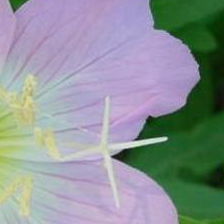

In [76]:
im

In [29]:
from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    
    # TODO: Process a PIL image for use in a PyTorch model
    image = Image.open(image)
   
   
    width, height = image.size 
    # resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    if width < height:
        
        new_height = int(height * 256 / width)
        image = image.resize((256, new_height))
    else:
        new_width = int(width *256 / height)
        image = image.resize((new_width, 256))
    width, height = image.size 
    # preparation for the 4 value tuple to be used for image.crop function
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width - left)
    bottom = (height - top)

    # Crop the center of the image
    im = image.crop((left, top, right, bottom))
    # Convert into Numpy array
    np_image = np.array(im)
    #Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1.
    np_image = np_image/255
    #list to array
    np_mean = np.array( [0.485, 0.456, 0.406])
    np_std = np.array([0.229, 0.224, 0.225])
    #the network expects the images to be normalized in a specific way.
    image_normalized = (np_image - np_mean) / np_std
    
    image_transpose = image_normalized.transpose(2,0,1)
    
    return torch.from_numpy(image_transpose)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [30]:
import numpy as np
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

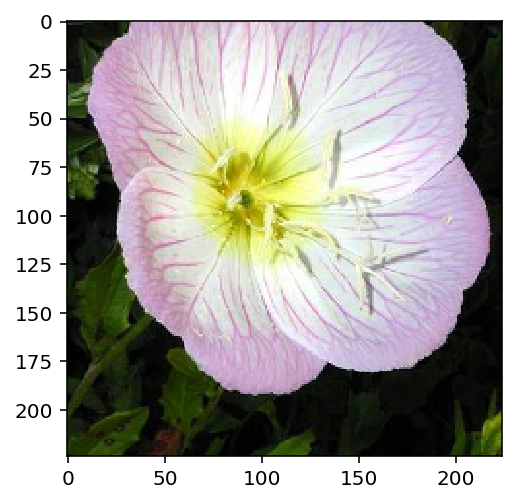

In [23]:
image_output = process_image("flowers/test/1/image_06743.jpg")
imshow(image_output)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [33]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
   
    with torch.no_grad():
        image = process_image(image_path)
        image.unsqueeze_(0)
        image = image.float()
        image = image.to(device)
        logps = model.forward(image)       
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(5, dim=1)
        top_p = top_p.tolist()[0]
        top_class = top_class.tolist()[0]
        
        idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx}
        labels = []
    for c in top_class:
        labels.append(cat_to_name[idx_to_class[c]])

    return top_p, labels
        
    
probs, classes = predict('flowers/test/54/image_05402.jpg', model)
print(probs)
print(classes)        

AttributeError: 'VGG' object has no attribute 'class_to_idx'

In [1]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
   
    with torch.no_grad():
        image = process_image(image_path)
        image.view(image.shape[0], -1)
        image = image.float()
        image = image.to(device)
        
        optimizer.zero_grad()
        logps = model.forward(image)       
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(5, dim=1)
        top_p = top_p.tolist()[0]
        top_class = top_class.tolist()[0]
        idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx}
        labels = []
    for c in top_class:
        labels.append(cat_to_name[idx_to_class[c]])

    return top_p, labels

In [2]:
#Set default tensor type, then move model and data to GPU
torch.set_default_tensor_type('torch.FloatTensor')
probs, classes = predict('flowers/test/1/image_06743.jpg', model)
print(probs)
print(classes)        

NameError: name 'torch' is not defined

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes
fig = plt.figure(figsize = (6,10))

#Create axes for flower
ax = fig.add_axes([.2, .4, .445, .445])

#Display + process image
result = process_image('flowers/test/1/image_06743.jpg')
ax = imshow(result, ax);

#Title for graph


#Predict image
probs, classes = predict('flowers/test/1/image_06743.jpg', model)

#Displays bar graph with axes
ax1 = fig.add_axes([0, -.355, .775, .775])

# Get range for probabilities
y_pos = np.arange(len(classes))

# Plot as a horizontal bar graph
plt.barh(y_pos, probs, align='center', alpha=0.5)
plt.yticks(y_pos, classes)
plt.xlabel('probabilities')
plt.show()